# Import python dataset

In [1]:
notebookName = 'DCGAN.ipynb'

In [2]:
k = 822

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
import numpy as np
import functools
import time

import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.optimizers import Adam
from tensorflow import reduce_mean
import gc
from sklearn.preprocessing import *
import joblib



In [5]:
tf.config.run_functions_eagerly(True)

In [6]:
os.makedirs('./output/Figures')
os.makedirs('./output/Figures/Individual')
os.makedirs('./output/Figures/Result')
os.makedirs('./output/Figures/Prediction')
os.makedirs('./output/Figures/Prediction/Different')
os.makedirs('./ganmodedls')
os.makedirs('./logs/reconstrunction_log_dir')
os.makedirs('./logs/generator')
os.makedirs('./logs/discriminator')
os.makedirs('./output/Figures/Loss')

## Load data

In [7]:
n_features = 7

In [8]:
import joblib
data01= np.loadtxt('../input/pollutant/01.txt') 
print(data01.shape)

data02= np.loadtxt('../input/pollutant/02.txt') 
print(data02.shape)

data04= np.loadtxt('../input/pollutant/04.txt') 
print(data04.shape)


groups = ['PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups = np.array(groups)
print(groups.shape)

groups2 = ['times','PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups2 = np.array(groups2)
print(groups2.shape)

with open("../input/pollutant/10_2_time.csv", "r", encoding="utf-8") as fr:
    times = [fr.readlines()]
    
times = np.array(times)
times = times.T

print('times = ',times[:,0].shape)
print(times[0,:])

(1419, 7)
(1419, 7)
(1419, 7)
(6,)
(7,)
times =  (1419,)
['00:10\n']


# Preparing Dataset

In [9]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data01)

X_train_scaled.shape 


(1419, 7)

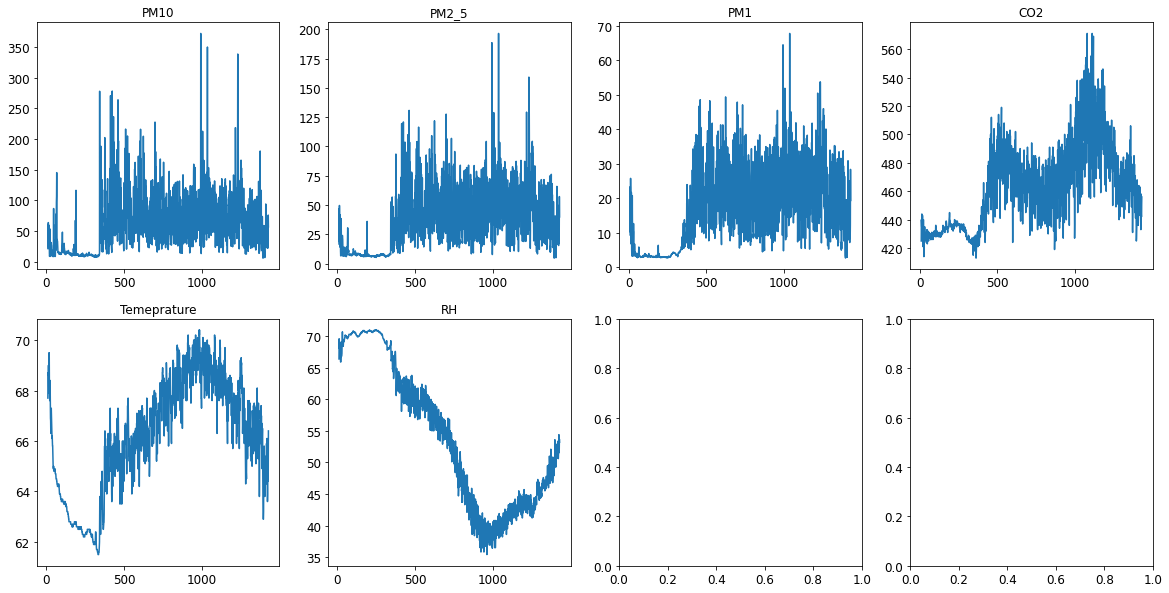

In [10]:
#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #a=i+1
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].set_title(group)
plt.savefig('./output/Figures/Individual/Sample_v'+str(k)+'.png')

# Train the GAN

### Preparing the training dataset

In [11]:
n = 0

(1319, 100, 7, 1)
(100, 7, 1)


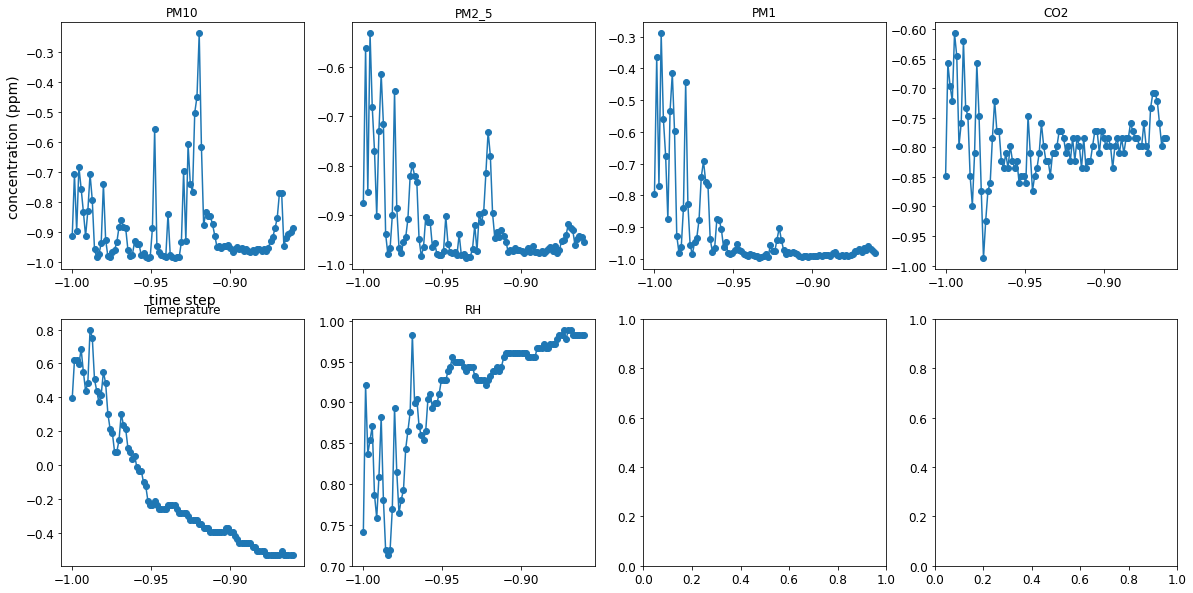

In [12]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)
#Individual sample dataset


print(X_train_concat[n].shape)
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat[n][:,0,-1], X_train_concat[n][:,i+1,-1], '-o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")



In [13]:
BATCH_SIZE = 32
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, n_features,1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE)

for data in train_dataset:
    print(data.shape)
    break

(32, 100, 7, 1)


In [14]:
gan = tf.keras.models.load_model('../input/ganmodels/DCGAN_v816_epoch_4000.h5', compile=False).layers
generator, discriminator = tf.keras.models.load_model('../input/ganmodels/DCGAN_v816_epoch_4000.h5', compile=False).layers  

# Predict with the GAN

In [15]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-2) 

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [(ntimes-1), 1]) 
    outp = tf.reshape(outp, [(ntimes-1), 1])
    print("input:",inp.shape)
    print("output:",outp.shape)
    
    return mse(inp, outp)

def optimize_coding(latent_values, real_coding, epochs, control_variable):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, control_variable)
        
    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding, control_variable):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes - 1), control_variable])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

# PM10

In [16]:
n = 500
epochs = 2000
epoch = 4000
predict_points = 1 #X_train.shape[0]-n-ntimes
control_variable = 2

In [17]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (

(101, 7)
(1419, 7)


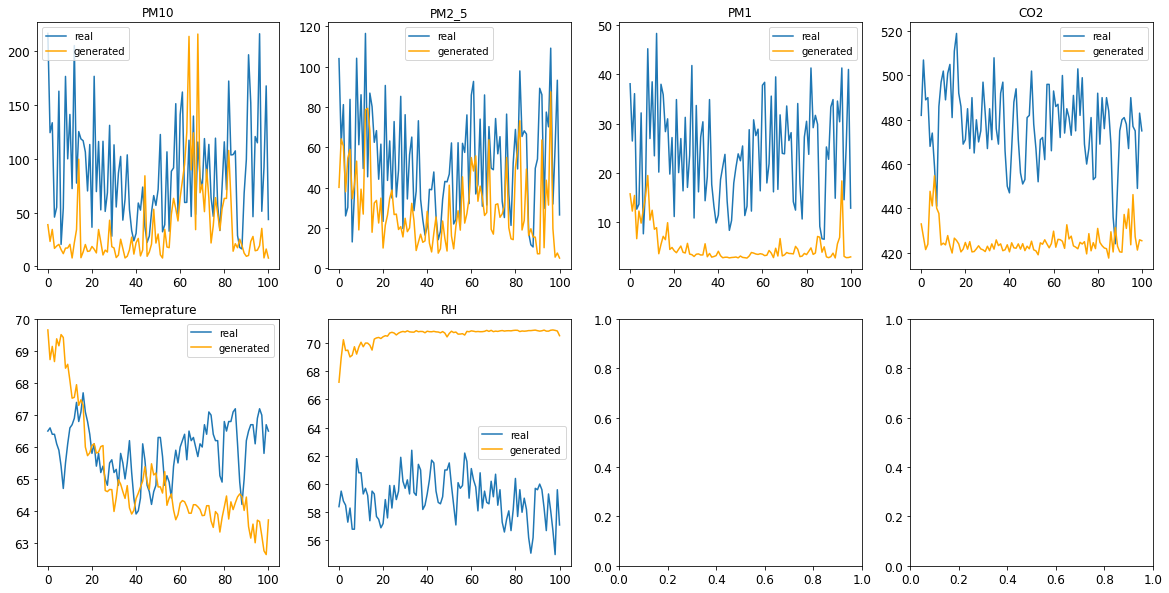

In [18]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Different/PM10entire_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# CO2

In [19]:
control_variable = 1

In [20]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (

(101, 7)
(1419, 7)


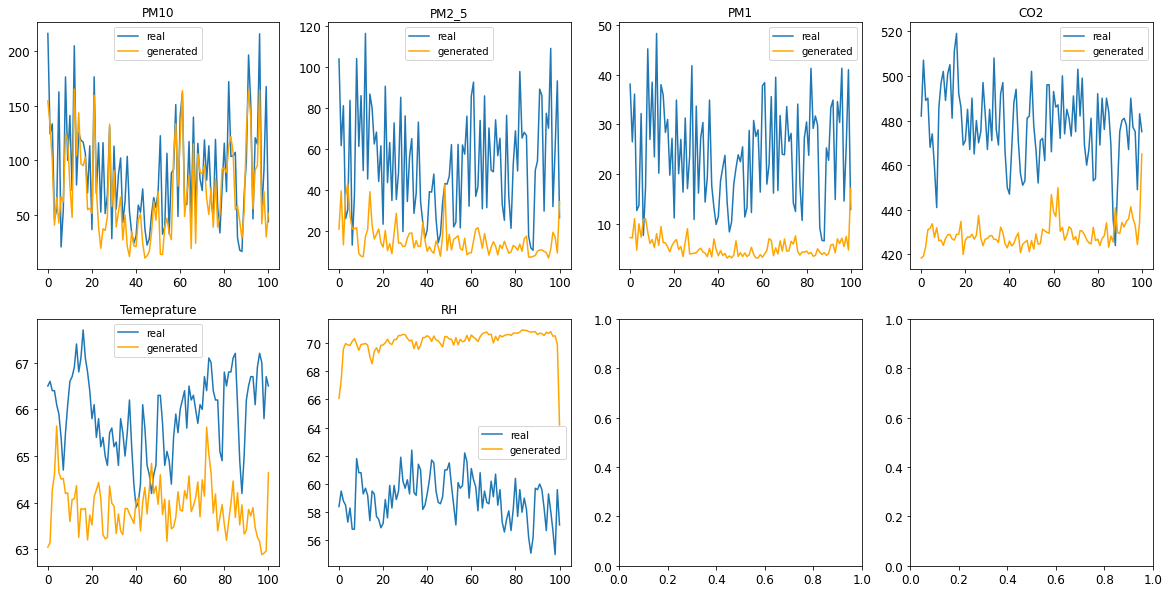

In [21]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Different/CO2_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# RH 

In [22]:
control_variable = 5

In [23]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (

(101, 7)
(1419, 7)


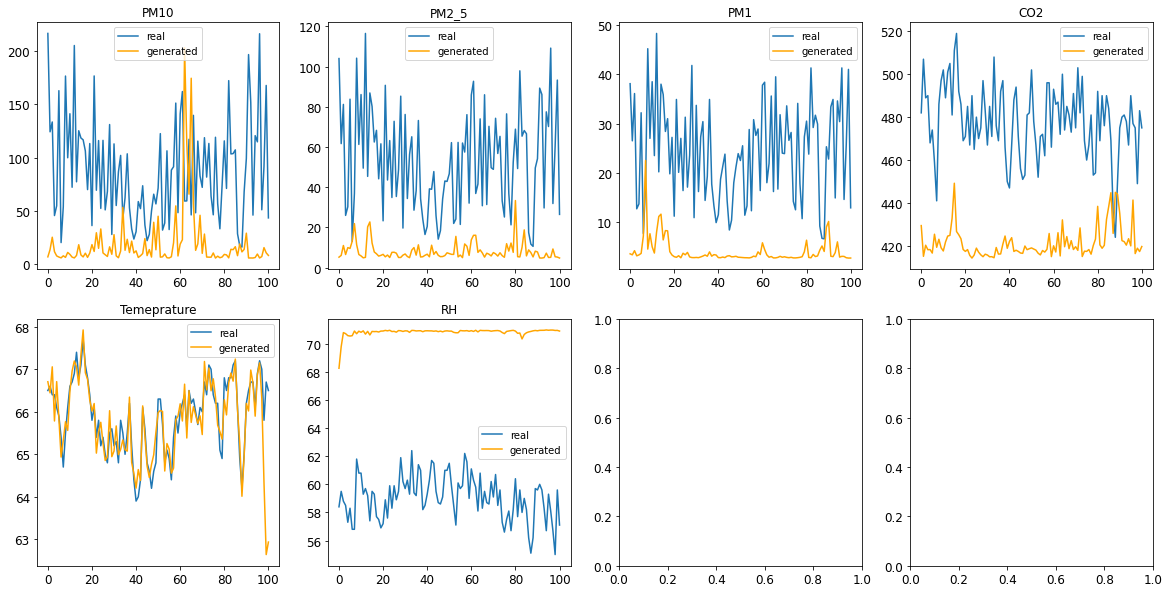

In [24]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Different/RH_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# Temperature

In [25]:
control_variable = 6

In [26]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (

(101, 7)
(1419, 7)


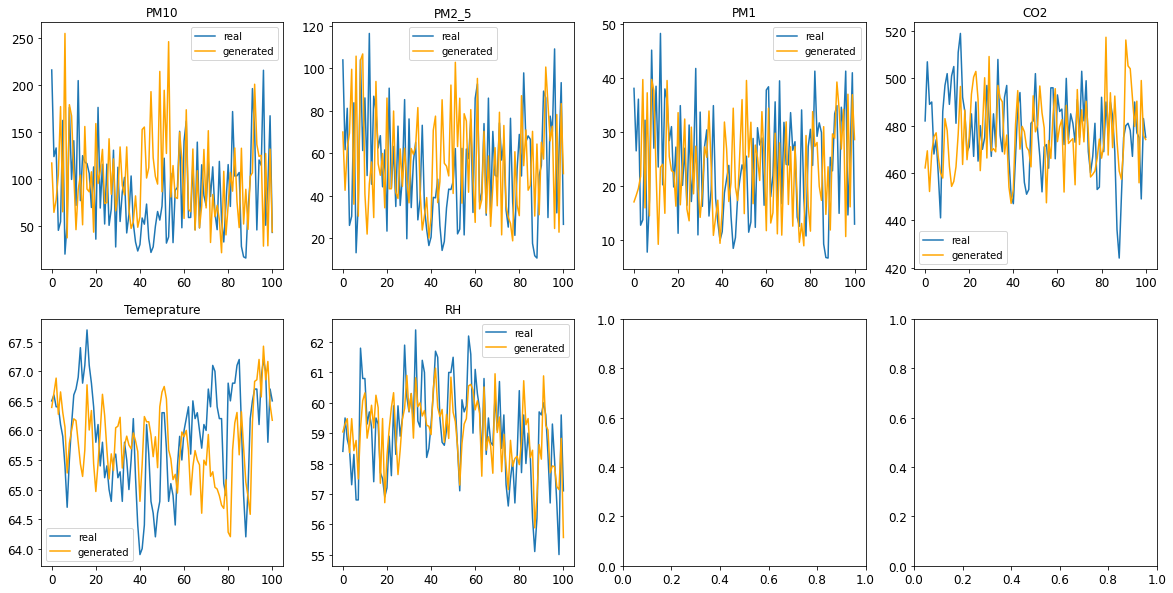

In [27]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Different/Temp_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# PM2.5

In [28]:
control_variable = 3

In [29]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (

(101, 7)
(1419, 7)


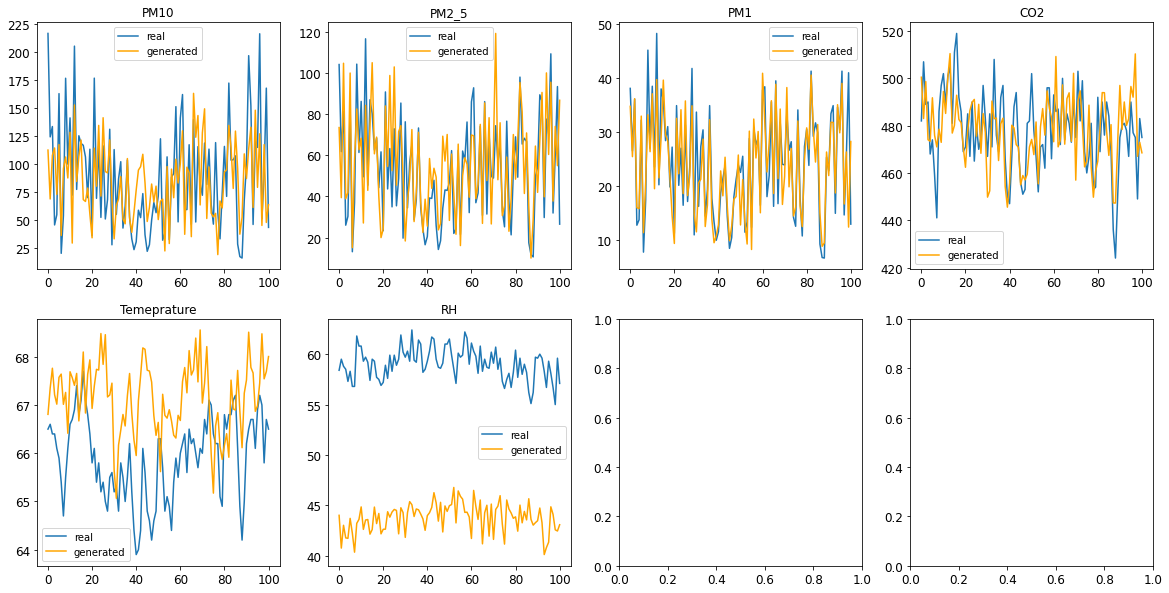

In [30]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Different/PM2_5_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# PM 1

In [31]:
control_variable = 4

In [32]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (99, 1)
output: (99, 1)
input: (

(101, 7)
(1419, 7)


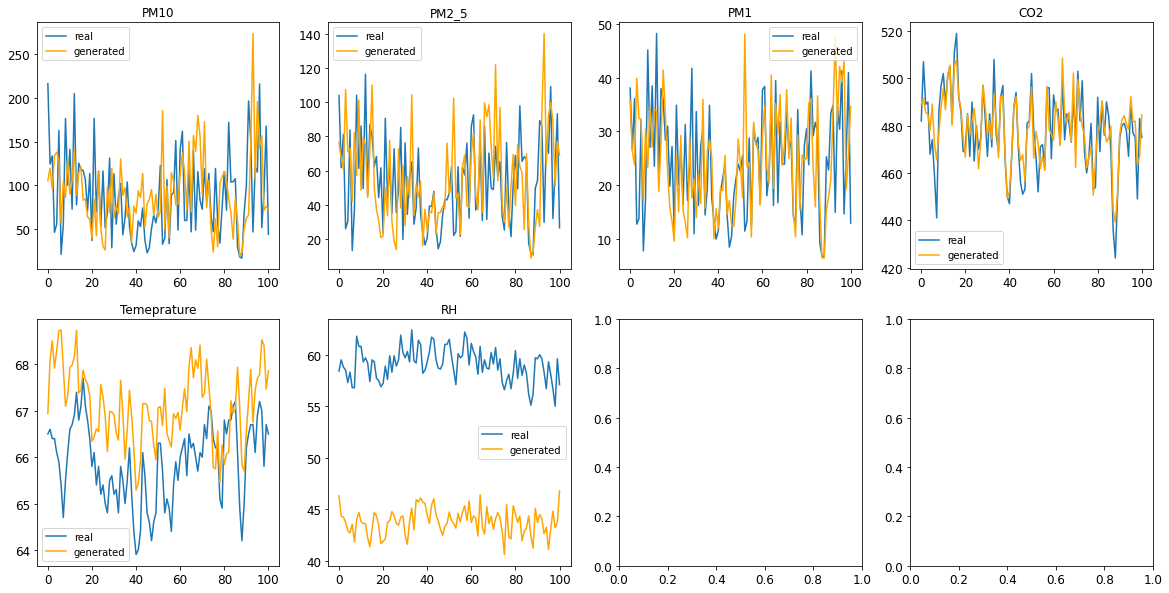

In [33]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

print(X_generated.shape)
print(X_train.shape)

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Different/PM1_v'+str(k)+'_epoch_'+str(epoch)+'.png')